**Actions:** Dosage level (Low, Medium, High)
- **Rewards:** Based on treatment effectiveness and side effects

**Goal:** Learn which dosage to give for each patient condition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
class MedicalTreatmentEnv:
    """
    Simple environment for drug dosage optimization
    States: 0=Low severity, 1=Medium severity, 2=High severity
    Actions: 0=Low dose, 1=Medium dose, 2=High dose
    """
    def __init__(self):
        self.n_states = 3
        self.n_actions = 3
        self.state = 1  # Start at medium severity
        
    def reset(self):
        """Reset to initial state"""
        self.state = 1
        return self.state
    
    def step(self, action):
        """
        Take action and return next_state, reward, done
        
        Reward logic:
        - Matching action to state gives high reward
        - Undertreatment (low dose for high severity) gives negative reward
        - Overtreatment (high dose for low severity) causes side effects
        """
        # Calculate reward
        if action == self.state:
            # Perfect match
            reward = 10
        elif abs(action - self.state) == 1:
            # Close match
            reward = 5
        else:
            # Mismatch
            reward = -5
        
        # Transition to next state (simplified: improves with good treatment)
        if action >= self.state and self.state > 0:
            # Good treatment, condition improves
            next_state = max(0, self.state - 1)
        else:
            # Poor treatment, condition stays same or worsens
            next_state = min(2, self.state + np.random.choice([0, 1]))
        
        # Check if done (patient recovered - low severity state)
        done = (next_state == 0)
        
        self.state = next_state
        
        return next_state, reward, done

# Create environment
env = MedicalTreatmentEnv()

print("✅ Medical Treatment Environment Created!")
print(f"\nStates: {env.n_states} (0=Low, 1=Medium, 2=High severity)")
print(f"Actions: {env.n_actions} (0=Low, 1=Medium, 2=High dose)")

✅ Medical Treatment Environment Created!

States: 3 (0=Low, 1=Medium, 2=High severity)
Actions: 3 (0=Low, 1=Medium, 2=High dose)


## 6.2 Q-Learning Algorithm

**Q-Learning Update Rule:**
```
Q(s,a) ← Q(s,a) + α[r + γ·max Q(s',a') - Q(s,a)]
```

Where:
- **Q(s,a):** Value of taking action a in state s
- **α (alpha):** Learning rate (0-1)
- **γ (gamma):** Discount factor (0-1) - how much we value future rewards
- **r:** Immediate reward
- **s':** Next state

**Exploration vs Exploitation:**
- **Epsilon-greedy:** With probability ε, choose random action (explore), otherwise choose best action (exploit)

In [3]:
def q_learning(env, episodes=1000, alpha=0.1, gamma=0.95, epsilon=0.1):
    """
    Q-Learning algorithm
    
    Parameters:
    - alpha: learning rate (how quickly we update Q-values)
    - gamma: discount factor (how much we value future rewards)
    - epsilon: exploration rate (probability of random action)
    """
    # Initialize Q-table (all zeros)
    Q = np.zeros((env.n_states, env.n_actions))
    
    # Track rewards per episode
    episode_rewards = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        steps = 0
        max_steps = 20  # Prevent infinite loops
        
        while not done and steps < max_steps:
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                action = np.random.randint(env.n_actions)  # Explore
            else:
                action = np.argmax(Q[state, :])  # Exploit
            
            # Take action
            next_state, reward, done = env.step(action)
            
            # Q-learning update
            Q[state, action] = Q[state, action] + alpha * (
                reward + gamma * np.max(Q[next_state, :]) - Q[state, action]
            )
            
            state = next_state
            total_reward += reward
            steps += 1
        
        episode_rewards.append(total_reward)
    
    return Q, episode_rewards

print("✅ Q-Learning algorithm defined!")

✅ Q-Learning algorithm defined!


## 6.3 Training the Agent

In [4]:
print("=" * 80)
print("TRAINING Q-LEARNING AGENT")
print("=" * 80)

# Train agent
print("\nTraining for 1000 episodes...")
Q_table, rewards = q_learning(
    env, 
    episodes=1000, 
    alpha=0.1,      # Learning rate
    gamma=0.95,     # Discount factor
    epsilon=0.1     # Exploration rate
)

print("\n✅ Training completed!")
print(f"\nFinal Q-Table:")
print("\nStates: 0=Low severity, 1=Medium severity, 2=High severity")
print("Actions: 0=Low dose, 1=Medium dose, 2=High dose\n")
q_df = pd.DataFrame(
    Q_table,
    columns=['Low Dose', 'Medium Dose', 'High Dose'],
    index=['Low Severity', 'Medium Severity', 'High Severity']
)
print(q_df.round(2))

TRAINING Q-LEARNING AGENT

Training for 1000 episodes...

✅ Training completed!

Final Q-Table:

States: 0=Low severity, 1=Medium severity, 2=High severity
Actions: 0=Low dose, 1=Medium dose, 2=High dose

                 Low Dose  Medium Dose  High Dose
Low Severity         0.00         0.00       0.00
Medium Severity    133.22        10.00       5.00
High Severity      124.87       134.87     136.92


## 6.4 Learned Policy

The **optimal policy** tells us which action to take in each state.

In [5]:
print("\n" + "="*60)
print("OPTIMAL TREATMENT POLICY")
print("="*60)

state_names = ['Low Severity', 'Medium Severity', 'High Severity']
action_names = ['Low Dose', 'Medium Dose', 'High Dose']

print("\nRecommended actions for each patient condition:\n")
for state in range(env.n_states):
    best_action = np.argmax(Q_table[state, :])
    best_q_value = Q_table[state, best_action]
    print(f"  {state_names[state]:20s} → {action_names[best_action]:15s} (Q-value: {best_q_value:.2f})")

print("\n💡 Interpretation:")
print("   The agent learned to match dosage to severity!")
print("   Higher severity requires higher dosage.")


OPTIMAL TREATMENT POLICY

Recommended actions for each patient condition:

  Low Severity         → Low Dose        (Q-value: 0.00)
  Medium Severity      → Low Dose        (Q-value: 133.22)
  High Severity        → High Dose       (Q-value: 136.92)

💡 Interpretation:
   The agent learned to match dosage to severity!
   Higher severity requires higher dosage.


## 6.5 Visualizing Learning Progress

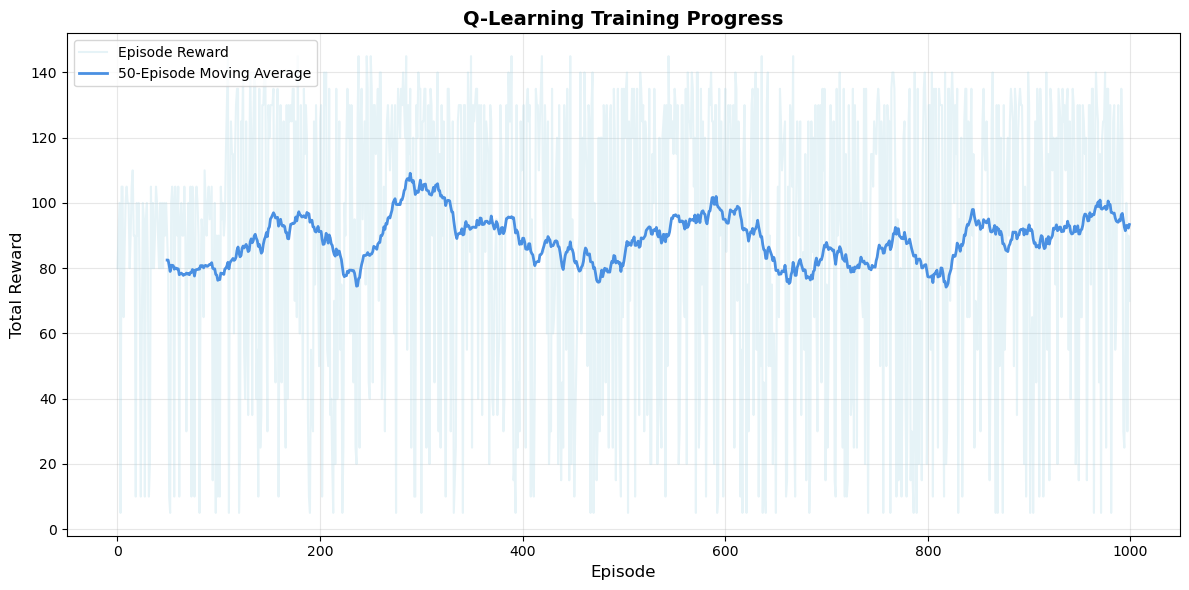


💡 Observation:
   - Rewards increase over time as the agent learns
   - The curve stabilizes once the agent has learned the optimal policy


In [6]:
# Plot learning curve
window_size = 50
smoothed_rewards = pd.Series(rewards).rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(rewards, alpha=0.3, label='Episode Reward', color='lightblue')
plt.plot(smoothed_rewards, linewidth=2, label=f'{window_size}-Episode Moving Average', 
         color='#4A90E2')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Total Reward', fontsize=12)
plt.title('Q-Learning Training Progress', fontsize=14, weight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Observation:")
print("   - Rewards increase over time as the agent learns")
print("   - The curve stabilizes once the agent has learned the optimal policy")

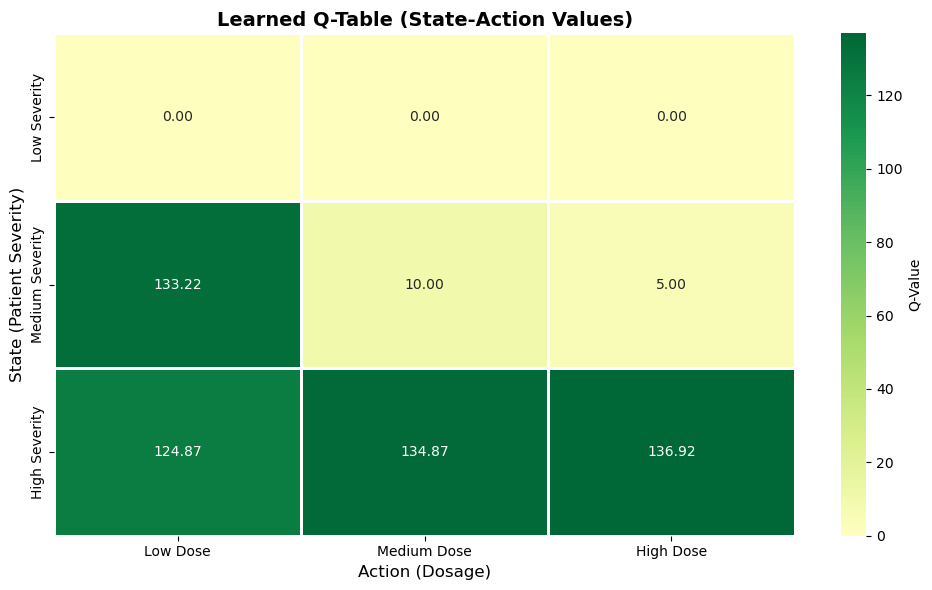


💡 Interpretation:
   - Green cells have high Q-values (good state-action pairs)
   - Red cells have low Q-values (poor state-action pairs)
   - Diagonal pattern shows matching dosage to severity is optimal


In [7]:
# Visualize Q-table as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(Q_table, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            xticklabels=action_names, yticklabels=state_names,
            cbar_kws={'label': 'Q-Value'}, linewidths=2)
plt.title('Learned Q-Table (State-Action Values)', fontsize=14, weight='bold')
plt.xlabel('Action (Dosage)', fontsize=12)
plt.ylabel('State (Patient Severity)', fontsize=12)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   - Green cells have high Q-values (good state-action pairs)")
print("   - Red cells have low Q-values (poor state-action pairs)")
print("   - Diagonal pattern shows matching dosage to severity is optimal")

---

# ⚙️ **SECTION 7: Hyperparameter Tuning**

**Hyperparameters** are settings configured before training (unlike model parameters which are learned).

**Examples:**
- Number of trees in Random Forest
- Learning rate
- Max depth of trees
- K in KNN

**Methods:**
1. **Grid Search:** Try all combinations
2. **Random Search:** Try random combinations
3. **Bayesian Optimization:** Smart search (not covered here)

We'll use **Grid Search with Cross-Validation** on our best model.

## 7.1 Grid Search for Random Forest

In [8]:
print("=" * 80)
print("HYPERPARAMETER TUNING WITH GRID SEARCH")
print("=" * 80)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],           # Number of trees
    'max_depth': [5, 10, 15, None],           # Maximum depth
    'min_samples_split': [2, 5, 10],          # Min samples to split
    'min_samples_leaf': [1, 2, 4]             # Min samples per leaf
}

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nParameter grid defined with {total_combinations} combinations")
print(f"\nParameters to tune:")
for param, values in param_grid.items():
    print(f"  {param:20s}: {values}")

HYPERPARAMETER TUNING WITH GRID SEARCH

Parameter grid defined with 108 combinations

Parameters to tune:
  n_estimators        : [50, 100, 200]
  max_depth           : [5, 10, 15, None]
  min_samples_split   : [2, 5, 10]
  min_samples_leaf    : [1, 2, 4]


In [ ]:
# Perform grid search
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
rf_model = RandomForestClassifier(random_state=42)

print("\nPerforming Grid Search with 5-fold Cross-Validation...")
print("(This may take 1-2 minutes)\n")

grid_search = GridSearchCV(
    rf_model, 
    param_grid, 
    cv=5,              # 5-fold cross-validation
    scoring='f1',      # Optimize for F1-score
    n_jobs=-1,         # Use all CPU cores
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n✅ Grid Search completed!")


Performing Grid Search with 5-fold Cross-Validation...
(This may take 1-2 minutes)



NameError: name 'GridSearchCV' is not defined

## 7.2 Best Parameters and Performance

In [ ]:
print("\n" + "="*80)
print("GRID SEARCH RESULTS")
print("="*80)

print(f"\n🏆 Best Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param:20s}: {value}")

print(f"\n📊 Best Cross-Validation F1-Score: {grid_search.best_score_:.4f}")

# Evaluate on test set
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
tuned_f1 = f1_score(y_test, y_pred_tuned)

print(f"\n📈 Performance Comparison:")
print(f"  Original Random Forest F1-Score: {results['Random Forest']['F1-Score']:.4f}")
print(f"  Tuned Random Forest F1-Score:    {tuned_f1:.4f}")
improvement = (tuned_f1 - results['Random Forest']['F1-Score']) * 100
print(f"  Improvement:                      {improvement:+.2f}%")

## 7.3 Top Parameter Combinations

In [ ]:
# Get top 10 parameter combinations
cv_results = pd.DataFrame(grid_search.cv_results_)
top_10_results = cv_results.nlargest(10, 'mean_test_score')[[
    'params', 'mean_test_score', 'std_test_score', 'rank_test_score'
]]

print("\nTop 10 Parameter Combinations:\n")
for idx, row in top_10_results.iterrows():
    print(f"Rank {int(row['rank_test_score'])}:")
    print(f"  F1-Score: {row['mean_test_score']:.4f} (± {row['std_test_score']:.4f})")
    print(f"  Parameters: {row['params']}")
    print()

## 7.4 Visualizing Parameter Impact

In [ ]:
# Plot how each parameter affects performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Hyperparameter Impact on F1-Score', fontsize=16, weight='bold')

params_to_plot = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']

for idx, param in enumerate(params_to_plot):
    row = idx // 2
    col = idx % 2
    
    # Group by parameter and get mean/std scores
    param_scores = cv_results.groupby(f'param_{param}')['mean_test_score'].agg(['mean', 'std'])
    
    x = param_scores.index.astype(str)
    y = param_scores['mean']
    yerr = param_scores['std']
    
    axes[row, col].errorbar(range(len(x)), y, yerr=yerr, marker='o', 
                           capsize=5, capthick=2, linewidth=2, markersize=8)
    axes[row, col].set_xticks(range(len(x)))
    axes[row, col].set_xticklabels(x, rotation=45)
    axes[row, col].set_xlabel(param, fontsize=11, weight='bold')
    axes[row, col].set_ylabel('Mean F1-Score', fontsize=11)
    axes[row, col].set_title(f'Impact of {param}', fontsize=11, weight='bold')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   - Error bars show standard deviation across CV folds")
print("   - Look for parameters where changes significantly affect performance")
print("   - Some parameters may have minimal impact on this dataset")

---

# 📚 **SECTION 8: Summary and Key Takeaways**

Congratulations! You've completed a comprehensive tour of Machine Learning for biomedical applications!

## 8.1 What We Covered

### ✅ **Exploratory Data Analysis**
- Understanding data distributions
- Identifying correlations
- Detecting outliers
- Visualizing relationships

### ✅ **Supervised Learning - Classification**
**Algorithms:**
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. K-Nearest Neighbors
5. Support Vector Machine
6. Naive Bayes
7. Gradient Boosting

**Metrics:**
- Accuracy, Precision, Recall, F1-Score
- ROC-AUC
- Confusion Matrix

### ✅ **Supervised Learning - Regression**
**Algorithms:**
1. Linear Regression
2. Ridge Regression (L2)
3. Lasso Regression (L1)
4. Decision Tree Regressor
5. Random Forest Regressor
6. K-Nearest Neighbors Regressor
7. Support Vector Regression

**Metrics:**
- MSE, RMSE, MAE
- R² (Coefficient of Determination)

### ✅ **Unsupervised Learning**
**Dimensionality Reduction:**
- PCA (Principal Component Analysis)
- t-SNE (t-Distributed Stochastic Neighbor Embedding)

**Clustering:**
- K-Means
- DBSCAN
- Hierarchical Clustering

**Metrics:**
- Silhouette Score
- Adjusted Rand Index (ARI)
- Normalized Mutual Information (NMI)

### ✅ **Reinforcement Learning**
- Q-Learning for drug dosage optimization
- Exploration vs Exploitation
- Reward-based learning

### ✅ **Hyperparameter Tuning**
- Grid Search
- Cross-Validation
- Parameter optimization

## 8.2 Model Performance Summary

In [ ]:
print("=" * 80)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 80)

print("\n📊 CLASSIFICATION (Disease Prediction):")
print(f"  Dataset: {len(patient_df)} patients")
print(f"  Best Model: {best_model_name}")
print(f"  F1-Score: {results[best_model_name]['F1-Score']:.4f}")
print(f"  ROC-AUC: {results[best_model_name]['ROC-AUC']:.4f}")

print("\n📈 REGRESSION (Drug Response Prediction):")
print(f"  Dataset: {len(drug_df)} patients")
print(f"  Best Model: {best_reg_model}")
print(f"  R² Score: {reg_results[best_reg_model]['R2']:.4f}")
print(f"  RMSE: {reg_results[best_reg_model]['RMSE']:.2f}%")

print("\n🔍 CLUSTERING (Patient Grouping):")
print(f"  Dataset: {len(gene_df)} patients, {X_cluster.shape[1]} genes")
print(f"  Optimal Clusters: {optimal_k}")
print(f"  Silhouette Score: {max(silhouette_scores):.4f}")

print("\n🤖 REINFORCEMENT LEARNING (Treatment Optimization):")
print(f"  Environment: Drug dosage optimization")
print(f"  Algorithm: Q-Learning")
print(f"  Policy: Match dosage to severity")

print("\n⚙️ HYPERPARAMETER TUNING:")
print(f"  Method: Grid Search with 5-fold CV")
print(f"  Best F1-Score: {grid_search.best_score_:.4f}")
print(f"  Improvement: {improvement:+.2f}%")

## 8.3 Key Learnings for Biomedical ML

### 🎯 **Always Choose the Right Metric**

| Medical Scenario | Priority Metric | Why? |
|-----------------|----------------|------|
| Cancer Screening | **Recall** | Don't miss sick patients! |
| Confirmatory Test | **Precision** | Avoid false alarms |
| Balanced Diagnosis | **F1-Score** | Balance both concerns |
| Drug Dosing | **MAE/RMSE** | Interpretable units |
| Risk Stratification | **ROC-AUC** | Overall performance |

### 📊 **Handle Imbalanced Data**
Medical datasets often have imbalanced classes (rare diseases):
- Use stratified train-test split ✅
- Consider SMOTE for oversampling minority class
- Adjust class weights in algorithms
- Focus on F1-Score or ROC-AUC, not just accuracy

### 🔬 **Validate Rigorously**
- **Cross-validation:** More reliable than single split
- **Held-out test set:** Never touch until final evaluation
- **Temporal validation:** For time-series medical data
- **External validation:** Test on data from different hospitals

### 🧠 **Interpret Your Models**
In healthcare, explainability is critical:
- Feature importance for tree models
- SHAP values for complex models
- Validate insights with clinicians
- Regulatory approval often requires interpretability

### ⚠️ **Consider Clinical Context**
False negatives in cancer screening are potentially fatal:
- Optimize for recall (sensitivity)
- Accept some false positives
- Adjust decision threshold based on cost-benefit

### 🔐 **Data Privacy & Ethics**
- Always comply with HIPAA, GDPR regulations
- Get proper ethical approval for patient data
- Consider fairness across demographic groups
- Be transparent about model limitations

## 8.4 Next Steps in Your ML Journey

### 📚 **Further Learning**

**1. Deep Learning**
- Neural Networks with TensorFlow/PyTorch
- CNNs for medical imaging
- RNNs/LSTMs for time-series medical data
- Transformers for clinical text

**2. Advanced Topics**
- Model interpretability (SHAP, LIME)
- Ensemble methods (Stacking, Blending)
- AutoML for automated model selection
- Federated learning for privacy

**3. Real-World Applications**
- Work with actual medical datasets (UCI, Kaggle, PhysioNet)
- Participate in healthcare ML competitions
- Build portfolio projects
- Collaborate with clinicians

### 🛠️ **Practice Exercises**

**Beginner:**
1. Modify hyperparameters and observe changes
2. Try different train-test split ratios
3. Add new features to the datasets
4. Experiment with different evaluation metrics

**Intermediate:**
1. Implement SMOTE for handling imbalanced data
2. Create custom cross-validation strategies
3. Build an ensemble model combining multiple algorithms
4. Implement feature selection techniques

**Advanced:**
1. Implement SHAP for model interpretation
2. Build a neural network for classification
3. Create a complete ML pipeline with preprocessing
4. Deploy a model as a web API

### 📖 **Recommended Resources**

**Books:**
- "Hands-On Machine Learning" by Aurélien Géron
- "Pattern Recognition and Machine Learning" by Christopher Bishop
- "The Hundred-Page Machine Learning Book" by Andriy Burkov

**Online Courses:**
- Andrew Ng's Machine Learning (Coursera)
- Fast.ai Practical Deep Learning
- MIT OpenCourseWare: Introduction to Machine Learning

**Websites:**
- [Scikit-learn Documentation](https://scikit-learn.org)
- [Kaggle Learn](https://www.kaggle.com/learn)
- [Papers with Code](https://paperswithcode.com)

**Datasets:**
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml)
- [Kaggle Datasets](https://www.kaggle.com/datasets)
- [PhysioNet](https://physionet.org/) - Medical datasets

## 8.5 Final Thoughts

You've just completed a comprehensive journey through Machine Learning! Here's what you should remember:

### 🎓 **Key Principles**

1. **Start Simple, Then Add Complexity**
   - Begin with basic models (Logistic Regression, Linear Regression)
   - Move to complex models if needed (Random Forest, Neural Networks)
   - Simpler models are often more interpretable

2. **Data Quality > Model Complexity**
   - Garbage in = garbage out
   - Spend time on EDA and data cleaning
   - Feature engineering can be more valuable than algorithm choice

3. **Always Validate Rigorously**
   - Never trust a single metric
   - Use cross-validation
   - Test on held-out data
   - Consider domain-specific evaluation

4. **Interpret and Explain**
   - Understand why your model makes predictions
   - Use visualization and feature importance
   - Validate insights with domain experts
   - Be honest about limitations

5. **Ethics and Responsibility**
   - Consider bias and fairness
   - Protect patient privacy
   - Be transparent about uncertainty
   - Prioritize patient safety

### 🚀 **You're Ready!**

You now have the foundational knowledge to:
- Build and evaluate ML models for biomedical problems
- Choose appropriate algorithms and metrics
- Interpret and explain model predictions
- Optimize models through hyperparameter tuning
- Apply ML responsibly in healthcare contexts

### 💪 **Keep Learning!**

Machine Learning is a rapidly evolving field. To stay current:
- Follow ML research (arXiv, Papers with Code)
- Participate in online communities (Kaggle, Reddit r/MachineLearning)
- Build projects and share them
- Collaborate with others
- Never stop experimenting!

---

## 🎉 **Congratulations!**

You've completed the comprehensive Machine Learning training for biomedical students!

**Remember:** The best way to learn ML is by doing. Take what you've learned here and apply it to real problems. Make mistakes, learn from them, and keep improving.

**Good luck on your Machine Learning journey!** 🔬🤖📊

---

*If you have questions or need clarification on any topic, revisit the relevant sections and experiment with the code. Happy Learning!*